# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import numpy as np
import hydra
import copy
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "unique-class"
    cfg.case.user.user_idx = 0
    cfg.case.user.num_data_points = 4
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

#     cfg.attack.regularization.total_variation.scale = 0.2
#     cfg.attack.regularization.total_variation.inner_exp = 2
#     cfg.attack.regularization.total_variation.outer_exp = 0.5
#     # cfg.attack.optim.signed = 'hard'
#     cfg.attack.optim.step_size_decay = 'cosine-decay'
#     cfg.attack.optim.warmup = 50
#     # cfg.attack.optim.step_size = 1e-2
#     cfg.attack.init = 'patterned-4'  # 'patterned-4'
#     cfg.attack.objective.task_regularization = .0
#     cfg.attack.regularization.features = .0
#     cfg.attack.regularization.total_variation.double_opponents = True
#     cfg.attack.regularization.deep_inversion = dict(scale=.0)

    cfg.attack.optim.max_iterations = 0

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      19:1 for target shape [4, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents (

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [5]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

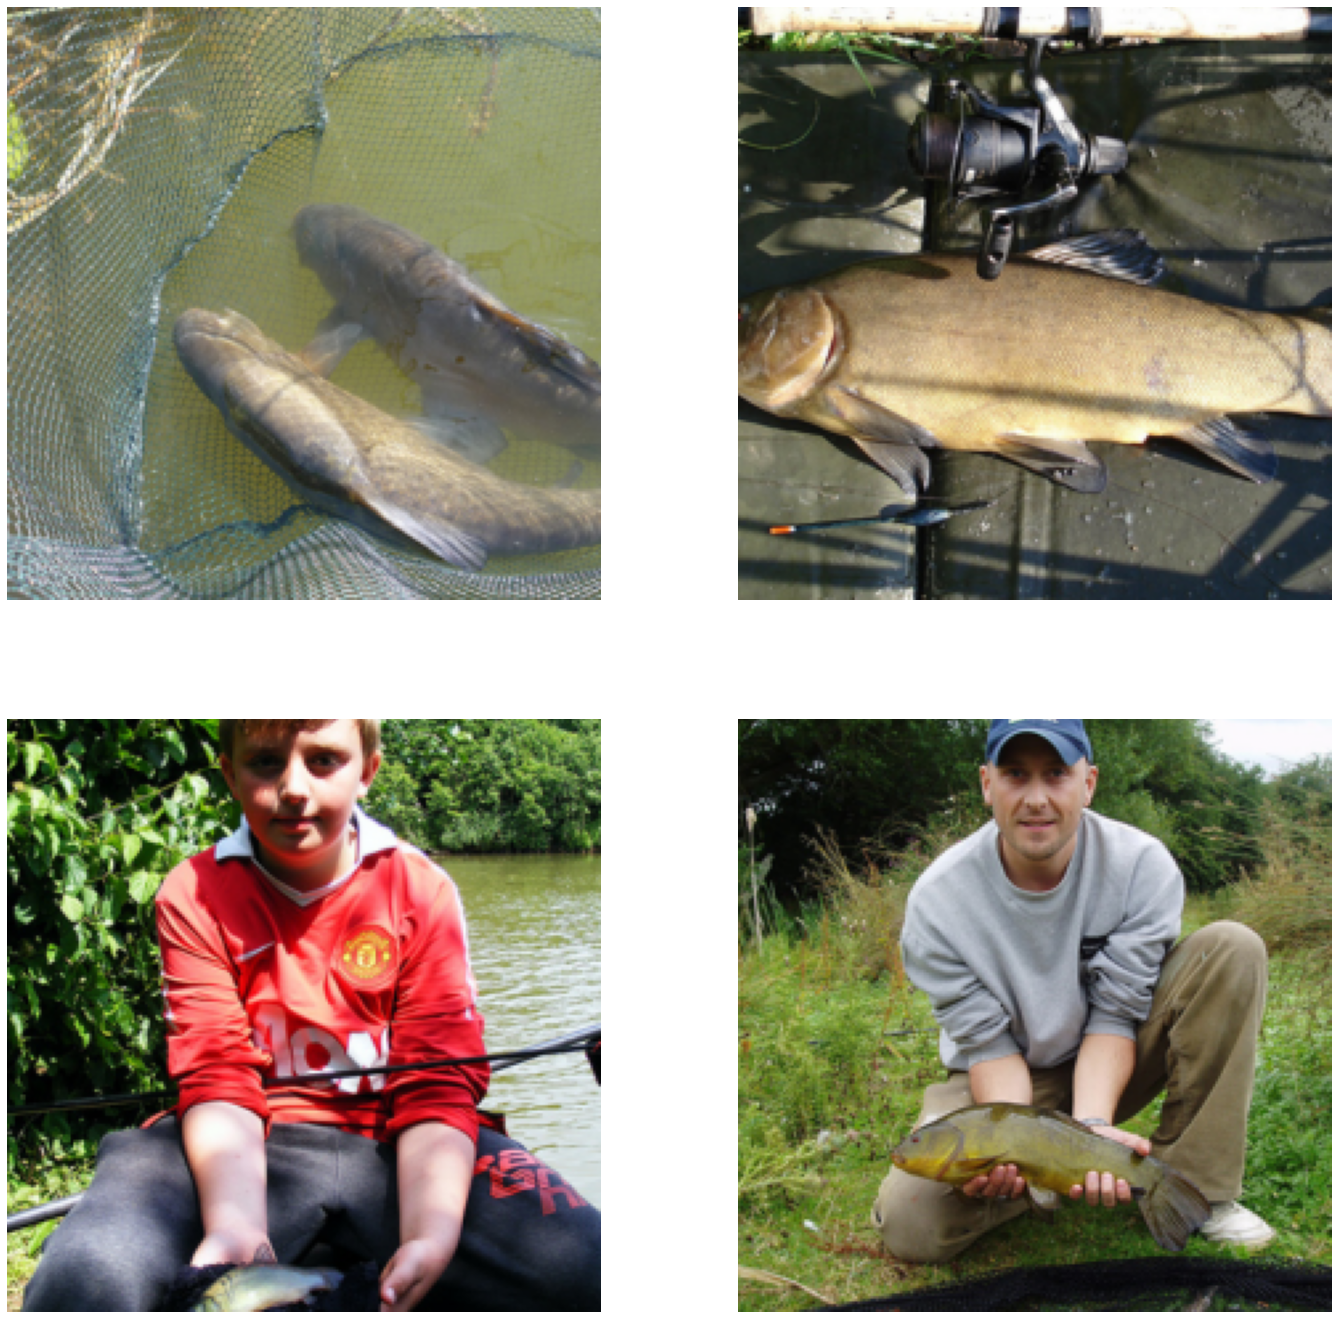

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

In [8]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [9]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

/Users/ywen/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:156: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16 currently.
  warnings.warn(error_message)


Optimal condidate solution with rec. loss 0.8943 selected.


In [10]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/Users/ywen/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0270 | PSNR: 15.68 | FMSE: 4.5987e+04 | LPIPS: 0.87|
 R-PSNR: 16.28 | IIP-pixel: 100.00% | SSIM: 0.1332 | Label Acc: 100.00%


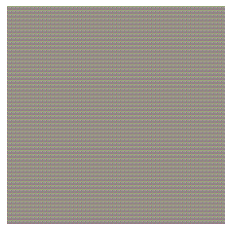

In [11]:
user.plot(reconstructed_user_data)

In [12]:
server.model(true_user_data['data'])[:, :5]

tensor([[ 288.4478, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 305.6094, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 220.6945, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 255.6788, 1000.0000, 1000.0000, 1000.0000, 1000.0000]],
       grad_fn=<SliceBackward0>)

In [13]:
target_img = true_user_data['data'][0]
target_img = server.random_transoformation(target_img)

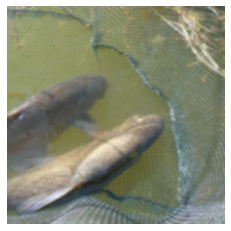

In [14]:
user.plot({'data': target_img.unsqueeze(0), 'labels': None})

In [15]:
server.model(target_img.unsqueeze(0))[:, :5]

tensor([[ 217.3961, 1000.0000, 1000.0000, 1000.0000, 1000.0000]],
       grad_fn=<SliceBackward0>)

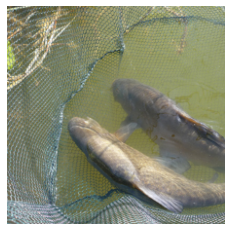

In [16]:
user.plot({'data': true_user_data['data'][0:1], 'labels': None})

In [17]:
server.model(true_user_data['data'])[:, :5]

tensor([[ 288.4478, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 305.6094, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 220.6945, 1000.0000, 1000.0000, 1000.0000, 1000.0000],
        [ 255.6788, 1000.0000, 1000.0000, 1000.0000, 1000.0000]],
       grad_fn=<SliceBackward0>)

In [56]:
server.reset_model()
server.fishing_attack_retrain(target_img, target_cls=0, dataset_len=2000)

100%|████████████████████████| 250/250 [03:06<00:00,  1.34batch/s, loss=1.88]


In [57]:
# extra_info['b_mv'] = -(float(server.model(target_img.unsqueeze(0))[0][0])) - 0.001
extra_info['b_mv'] = 0
extra_info['b_mv_non'] = 0
server.reconfigure_model('fishing_attack', extra_info=extra_info)

In [58]:
server.model(true_user_data['data'])[:, :5]

tensor([[-2.3851,  4.4368,  8.8197,  8.6727,  7.6042],
        [ 2.2995,  2.9258,  2.5232,  5.5593,  5.3605],
        [-0.2502, -0.6413,  2.6504,  0.5020,  3.7249],
        [10.2637,  3.4094,  4.3958,  4.1293,  4.5971]],
       grad_fn=<SliceBackward0>)

In [59]:
server.model(true_user_data['data'])[:, true_user_data['labels']]

tensor([[-2.3851, -2.3851, -2.3851, -2.3851],
        [ 2.2995,  2.2995,  2.2995,  2.2995],
        [-0.2502, -0.2502, -0.2502, -0.2502],
        [10.2637, 10.2637, 10.2637, 10.2637]], grad_fn=<IndexBackward0>)

In [60]:
server.model(target_img.unsqueeze(0))[:, :5]

tensor([[-2.2101,  6.6721,  8.2089, 10.6466, 10.8533]],
       grad_fn=<SliceBackward0>)

In [61]:
singl_gradients, single_losses = server.cal_single_gradients(attacker, true_user_data)
server.print_gradients_norm(singl_gradients, single_losses)

grad norm         loss
401.3415832519531 16.960670471191406
279.8293762207031 10.297481536865234
171.27256774902344 10.383769989013672
210.98939514160156 2.7937514781951904
